In [29]:
from google.colab import drive
drive.mount('/content/drive')

import sys
FOLDERNAME = 'ML_final_project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install dagshub mlflow -q
!pip install statsmodels -q
!pip install scikit-learn -q

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib

import dagshub
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from mlflow.entities import Experiment
from mlflow.entities.lifecycle_stage import LifecycleStage
import os

In [32]:
dagshub.init(repo_owner='skara-21', repo_name='ML_Final_Project', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/skara-21/ML_Final_Project.mlflow')

client = MlflowClient()
experiment_name = "SARIMA_Training"

try:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment:
        if experiment.lifecycle_stage == LifecycleStage.DELETED:
            try:
                client.restore_experiment(experiment.experiment_id)
            except Exception as e:
                client.delete_experiment(experiment.experiment_id, True)
                experiment = None

    if experiment is None:
        experiment_id = client.create_experiment(experiment_name)
    else:
        mlflow.set_experiment(experiment_name)
        experiment_id = experiment.experiment_id

except MlflowException as e:
    pass
except Exception as e:
    pass

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Initialized MLflow to track repo "skara-21/ML_Final_Project"

Repository skara-21/ML_Final_Project initialized!

In [33]:
class WalmartSARIMAForecaster:

    def __init__(self, experiment_name="SARIMA_Training"):
        self.experiment_name = experiment_name
        self.models = {}
        self.forecasts = {}
        self.best_params = {}
        self.scaler = StandardScaler()
        mlflow.set_experiment(self.experiment_name)

    def load_data(self, drive_folder_path=None):
        with mlflow.start_run(run_name="SARIMA_Data_Loading"):
            if drive_folder_path is None:
                drive_folder_path = f'/content/drive/My Drive/{FOLDERNAME}/data/'

            train_path = os.path.join(drive_folder_path, 'train.csv')
            test_path = os.path.join(drive_folder_path, 'test.csv')
            stores_path = os.path.join(drive_folder_path, 'stores.csv')
            features_path = os.path.join(drive_folder_path, 'features.csv')

            files_to_check = [
                ('train.csv', train_path),
                ('test.csv', test_path),
                ('stores.csv', stores_path),
                ('features.csv', features_path)
            ]

            try:
                self.train_df = pd.read_csv(train_path)
                self.test_df = pd.read_csv(test_path)

                if os.path.exists(stores_path):
                    self.stores_df = pd.read_csv(stores_path)

                if os.path.exists(features_path):
                    self.features_df = pd.read_csv(features_path)

            except Exception as e:
                raise

            mlflow.log_param("data_source", "Google Drive")
            mlflow.log_param("drive_folder_path", drive_folder_path)
            mlflow.log_param("train_shape", self.train_df.shape)
            mlflow.log_param("test_shape", self.test_df.shape)
            mlflow.log_param("date_range_train", f"{self.train_df['Date'].min()} to {self.train_df['Date'].max()}")

            summary_path = os.path.join(drive_folder_path, 'data_summary.txt')
            with open(summary_path, 'w') as f:
                f.write(f"Walmart SARIMA Data Summary\n")
                f.write(f"Generated: {datetime.now()}\n")
                f.write(f"Train shape: {self.train_df.shape}\n")
                f.write(f"Test shape: {self.test_df.shape}\n")
                f.write(f"Date range: {self.train_df['Date'].min()} to {self.train_df['Date'].max()}\n")

            return drive_folder_path

    def explore_data(self):
        with mlflow.start_run(run_name="SARIMA_EDA"):
            self.train_df['Date'] = pd.to_datetime(self.train_df['Date'])
            self.test_df['Date'] = pd.to_datetime(self.test_df['Date'])

            mlflow.log_metric("num_stores", self.train_df['Store'].nunique())
            mlflow.log_metric("num_departments", self.train_df['Dept'].nunique())
            mlflow.log_metric("total_combinations", len(self.train_df[['Store', 'Dept']].drop_duplicates()))

            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            axes[0,0].hist(self.train_df['Weekly_Sales'], bins=50, alpha=0.7)
            axes[0,0].set_title('Distribution of Weekly Sales')
            axes[0,0].set_xlabel('Weekly Sales')

            store_sales = self.train_df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)
            axes[0,1].bar(range(len(store_sales)), store_sales.values)
            axes[0,1].set_title('Average Sales by Store')
            axes[0,1].set_xlabel('Store Rank')
            axes[0,1].set_ylabel('Average Weekly Sales')

            monthly_sales = self.train_df.groupby(self.train_df['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
            axes[1,0].plot(monthly_sales.index.astype(str), monthly_sales.values)
            axes[1,0].set_title('Total Sales Over Time')
            axes[1,0].tick_params(axis='x', rotation=45)

            holiday_sales = self.train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
            axes[1,1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values)
            axes[1,1].set_title('Average Sales: Holiday vs Non-Holiday')

            plt.tight_layout()
            plt.savefig('eda_plots.png', dpi=300, bbox_inches='tight')
            mlflow.log_artifact('eda_plots.png')
            plt.show()

            mlflow.log_metric("avg_weekly_sales", self.train_df['Weekly_Sales'].mean())
            mlflow.log_metric("sales_std", self.train_df['Weekly_Sales'].std())
            mlflow.log_metric("holiday_sales_boost",
                            (holiday_sales[True] - holiday_sales[False]) / holiday_sales[False] * 100)

    def preprocess_data(self):
        with mlflow.start_run(run_name="SARIMA_Preprocessing"):
            self.train_df = self.train_df.sort_values(['Store', 'Dept', 'Date'])
            self.test_df = self.test_df.sort_values(['Store', 'Dept', 'Date'])

            store_dept_stats = []
            all_combinations = self.train_df[['Store', 'Dept']].drop_duplicates()

            for _, row in all_combinations.iterrows():
                store_id = row['Store']
                dept_id = row['Dept']

                combo_data = self.train_df[(self.train_df['Store'] == store_id) &
                                          (self.train_df['Dept'] == dept_id)]

                non_zero_sales = combo_data[combo_data['Weekly_Sales'] > 0]

                store_dept_stats.append({
                    'Store': store_id,
                    'Dept': dept_id,
                    'total_records': len(combo_data),
                    'non_zero_records': len(non_zero_sales),
                    'avg_sales': combo_data['Weekly_Sales'].mean(),
                    'total_sales': combo_data['Weekly_Sales'].sum()
                })

            stats_df = pd.DataFrame(store_dept_stats)

            good_combinations = stats_df[
                (stats_df['total_records'] >= 30) &
                (stats_df['non_zero_records'] >= 10) &
                (stats_df['avg_sales'] > 0)
            ].copy()

            good_combinations = good_combinations.sort_values('total_sales', ascending=False)

            self.store_dept_combinations = good_combinations[['Store', 'Dept']]

            mlflow.log_param("missing_values_train", self.train_df.isnull().sum().sum())
            mlflow.log_param("missing_values_test", self.test_df.isnull().sum().sum())
            mlflow.log_param("total_combinations", len(all_combinations))
            mlflow.log_param("good_combinations", len(good_combinations))
            mlflow.log_param("avg_records_per_combination", good_combinations['total_records'].mean())

            stats_df.to_csv('combination_analysis.csv', index=False)
            mlflow.log_artifact('combination_analysis.csv')

    def check_stationarity(self, series, title="Time Series"):
        adf_test = adfuller(series.dropna())
        adf_p_value = adf_test[1]

        kpss_test = kpss(series.dropna())
        kpss_p_value = kpss_test[1]

        return adf_p_value < 0.05 and kpss_p_value > 0.05

    def analyze_time_series(self, store_id, dept_id):
        ts_data = self.train_df[(self.train_df['Store'] == store_id) &
                               (self.train_df['Dept'] == dept_id)].copy()

        if len(ts_data) == 0:
            return None

        ts_data = ts_data.set_index('Date')['Weekly_Sales'].sort_index()
        ts_data = ts_data.asfreq('W').interpolate(method='linear')

        if len(ts_data) >= 104:
            decomposition = seasonal_decompose(ts_data, model='additive', period=52)

            fig, axes = plt.subplots(4, 1, figsize=(15, 12))
            decomposition.observed.plot(ax=axes[0], title='Original')
            decomposition.trend.plot(ax=axes[1], title='Trend')
            decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
            decomposition.resid.plot(ax=axes[3], title='Residual')
            plt.tight_layout()
            plt.show()

        is_stationary = self.check_stationarity(ts_data, f"Store {store_id} Dept {dept_id}")

        fig, axes = plt.subplots(2, 1, figsize=(15, 8))
        plot_acf(ts_data.dropna(), ax=axes[0], lags=40)
        plot_pacf(ts_data.dropna(), ax=axes[1], lags=40)
        plt.tight_layout()
        plt.show()

        return ts_data, is_stationary

# CELL 4: Model Training Methods
    def check_seasonality_strength(self, series, period):
        try:
            if len(series) < 2 * period:
                return 0.0

            from statsmodels.tsa.stattools import acf

            max_lags = min(period + 5, len(series) - 1)
            if max_lags < period:
                return 0.0

            autocorrs = acf(series, nlags=max_lags, fft=False)
            seasonal_autocorr = abs(autocorrs[period]) if period < len(autocorrs) else 0.0

            if len(series) >= 2 * period:
                series_array = np.array(series)
                seasonal_means = []
                for i in range(period):
                    seasonal_values = series_array[i::period]
                    if len(seasonal_values) > 1:
                        seasonal_means.append(np.mean(seasonal_values))

                if len(seasonal_means) > 1:
                    seasonal_cv = np.std(seasonal_means) / (np.mean(seasonal_means) + 1e-10)
                    seasonality_score = max(seasonal_autocorr, seasonal_cv)
                else:
                    seasonality_score = seasonal_autocorr
            else:
                seasonality_score = seasonal_autocorr

            return min(seasonality_score, 1.0)

        except Exception:
            return 0.0

    def fit_best_arima(self, series):
        best_aic = np.inf
        best_order = None

        arima_orders = [
            (0, 1, 0),
            (1, 1, 0),
            (0, 1, 1),
            (1, 1, 1),
            (2, 1, 0),
            (0, 1, 2),
            (2, 1, 1),
            (1, 1, 2),
        ]

        import gc

        for order in arima_orders:
            try:
                model = ARIMA(series, order=order)
                fitted_model = model.fit(method='lbfgs')
                aic = fitted_model.aic

                if not np.isnan(aic) and not np.isinf(aic) and aic < best_aic:
                    best_aic = aic
                    best_order = order

                    if aic < 1000 and order in [(0,1,0), (1,1,0), (0,1,1), (1,1,1)]:
                        break

                del fitted_model
                del model
                gc.collect()

            except Exception as e:
                gc.collect()
                continue

        if best_order is None:
            return (0, 1, 0), (0, 0, 0, 0), 1200.0

        return best_order, (0, 0, 0, 0), best_aic

    def fit_best_sarima(self, series, seasonal_period):
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None

        sarima_combinations = [
            ((0, 1, 0), (0, 1, 0)),
            ((1, 1, 0), (1, 0, 0)),
            ((0, 1, 1), (0, 1, 0)),
            ((1, 1, 1), (1, 1, 0)),
            ((1, 1, 1), (0, 1, 1)),
            ((1, 1, 1), (1, 1, 1)),
        ]

        import gc

        for (p, d, q), (P, D, Q) in sarima_combinations:
            try:
                order = (p, d, q)
                seasonal_order = (P, D, Q, seasonal_period)

                model = SARIMAX(
                    series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )

                fitted_model = model.fit(
                    disp=False,
                    maxiter=20,
                    method='lbfgs'
                )

                aic = fitted_model.aic

                if not np.isnan(aic) and not np.isinf(aic) and aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_seasonal_order = seasonal_order

                    if aic < 1500:
                        break

                del fitted_model
                del model
                gc.collect()

            except Exception as e:
                gc.collect()
                continue

        if best_order is None:
            return self.fit_best_arima(series)

        return best_order, best_seasonal_order, best_aic

    def find_optimal_sarima_params_memory_efficient(self, series, seasonal_period=52):
        clean_series = series.dropna()

        if len(clean_series) < 10:
            return (1, 1, 1), (0, 0, 0, 0), np.inf

        seasonality_strength = self.check_seasonality_strength(clean_series, seasonal_period)
        data_length = len(clean_series)

        use_seasonal = (
            seasonality_strength > 0.3 and
            data_length >= 104 and
            seasonal_period <= data_length / 3
        )

        if not use_seasonal:
            return self.fit_best_arima(clean_series)
        else:
            return self.fit_best_sarima(clean_series, seasonal_period)

# CELL 5: Training Pipeline
    def train_sarima_models(self, max_combinations=50):
        import gc

        with mlflow.start_run(run_name="SARIMA_Model_Training"):
            if len(self.store_dept_combinations) == 0:
                return

            colab_safe_limit = min(max_combinations, 30)
            if max_combinations > 30:
                max_combinations = colab_safe_limit

            trained_combinations = 0
            successful_models = 0
            model_scores = []

            max_to_process = min(max_combinations, len(self.store_dept_combinations))

            def check_memory():
                try:
                    import psutil
                    memory_percent = psutil.virtual_memory().percent
                    return memory_percent
                except:
                    return 0

            for idx, (_, row) in enumerate(self.store_dept_combinations.head(max_to_process).iterrows()):
                store_id = row['Store']
                dept_id = row['Dept']

                memory_usage = check_memory()
                if memory_usage > 85:
                    gc.collect()
                    memory_usage = check_memory()
                    if memory_usage > 90:
                        break

                try:
                    ts_data = self.train_df[(self.train_df['Store'] == store_id) &
                                           (self.train_df['Dept'] == dept_id)].copy()

                    ts_data = ts_data.sort_values('Date')
                    ts_data['Date'] = pd.to_datetime(ts_data['Date'])
                    ts_data = ts_data.set_index('Date')['Weekly_Sales']

                    non_zero_data = ts_data[ts_data > 0]

                    if len(non_zero_data) < 15:
                        ts_data = ts_data.clip(lower=1.0)
                    else:
                        ts_data = non_zero_data

                    ts_data = ts_data.asfreq('W', method='pad')
                    ts_data = ts_data.fillna(method='ffill').fillna(method='bfill')
                    ts_data = ts_data.fillna(ts_data.mean())

                    order, seasonal_order, aic = self.find_optimal_sarima_params_memory_efficient(ts_data)

                    if aic == np.inf or aic > 10000:
                        key = f"{store_id}_{dept_id}"
                        self.models[key] = None
                        self.best_params[key] = {
                            'order': (0, 0, 0),
                            'seasonal_order': (0, 0, 0, 0),
                            'aic': np.inf,
                            'mae': 0,
                            'rmse': 0,
                            'data_points': len(ts_data),
                            'prediction_method': 'average',
                            'average_value': ts_data.mean()
                        }
                        successful_models += 1
                        continue

                    train_size = max(len(ts_data) - 4, int(len(ts_data) * 0.9))
                    train_series = ts_data[:train_size]
                    test_series = ts_data[train_size:]

                    if seasonal_order[3] > 0:
                        seasonal_order = (min(1, seasonal_order[0]),
                                        min(1, seasonal_order[1]),
                                        min(1, seasonal_order[2]),
                                        seasonal_order[3])

                    model = SARIMAX(
                        train_series,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )

                    fitted_model = model.fit(disp=False, maxiter=30)

                    if len(test_series) > 0:
                        forecast = fitted_model.forecast(steps=len(test_series))
                        mae = mean_absolute_error(test_series, forecast)
                        rmse = np.sqrt(mean_squared_error(test_series, forecast))
                    else:
                        mae = rmse = 0

                    key = f"{store_id}_{dept_id}"
                    self.models[key] = fitted_model
                    self.best_params[key] = {
                        'order': order,
                        'seasonal_order': seasonal_order,
                        'aic': aic,
                        'mae': mae,
                        'rmse': rmse,
                        'data_points': len(ts_data),
                        'prediction_method': 'sarima'
                    }

                    model_scores.append({
                        'Store': store_id,
                        'Dept': dept_id,
                        'AIC': aic,
                        'MAE': mae,
                        'RMSE': rmse,
                        'Data_Points': len(ts_data)
                    })

                    successful_models += 1

                    if (idx + 1) % 5 == 0:
                        gc.collect()

                except Exception as e:
                    gc.collect()

                trained_combinations += 1

            gc.collect()

            mlflow.log_param("trained_combinations", trained_combinations)
            mlflow.log_param("successful_models", successful_models)

            if model_scores:
                avg_aic = np.mean([score['AIC'] for score in model_scores if score['AIC'] != np.inf])
                avg_mae = np.mean([score['MAE'] for score in model_scores])
                avg_rmse = np.mean([score['RMSE'] for score in model_scores])

                mlflow.log_metric("avg_aic", avg_aic)
                mlflow.log_metric("avg_mae", avg_mae)
                mlflow.log_metric("avg_rmse", avg_rmse)

                scores_df = pd.DataFrame(model_scores)
                scores_df.to_csv('sarima_model_scores.csv', index=False)
                mlflow.log_artifact('sarima_model_scores.csv')

# CELL 6: Forecasting and Submission Generation
    def generate_forecasts(self, save_to_drive=True, drive_folder_path=None):
        with mlflow.start_run(run_name="SARIMA_Forecasting"):
            if 'Id' in self.test_df.columns:
                submission = self.test_df[['Id']].copy()
            else:
                submission = self.test_df.copy()
                submission['Id'] = range(1, len(submission) + 1)
                submission = submission[['Id']].copy()

            submission['Weekly_Sales'] = 0

            successful_forecasts = 0
            total_forecasts = 0
            zero_predictions = 0
            fallback_predictions = 0

            for idx, row in self.test_df.iterrows():
                store_id = row['Store']
                dept_id = row['Dept']
                test_date = pd.to_datetime(row['Date'])

                key = f"{store_id}_{dept_id}"
                total_forecasts += 1

                predicted_value = 0

                if key in self.models and self.models[key] is not None:
                    try:
                        hist_data = self.train_df[(self.train_df['Store'] == store_id) &
                                                 (self.train_df['Dept'] == dept_id)].copy()

                        if len(hist_data) > 0:
                            hist_data = hist_data.set_index('Date')['Weekly_Sales'].sort_index()
                            last_date = pd.to_datetime(hist_data.index.max())

                            steps = max(1, ((test_date - last_date).days // 7))

                            if steps > 0 and steps <= 52:
                                forecast = self.models[key].forecast(steps=steps)
                                predicted_value = max(0, forecast.iloc[-1])
                                successful_forecasts += 1
                            else:
                                predicted_value = max(0, hist_data.mean())
                                fallback_predictions += 1

                    except Exception as e:
                        hist_data = self.train_df[(self.train_df['Store'] == store_id) &
                                                 (self.train_df['Dept'] == dept_id)]['Weekly_Sales']
                        if len(hist_data) > 0:
                            predicted_value = max(0, hist_data.mean())
                            fallback_predictions += 1

                elif key in self.best_params and 'prediction_method' in self.best_params[key]:
                    if self.best_params[key]['prediction_method'] == 'average':
                        predicted_value = max(0, self.best_params[key]['average_value'])
                        fallback_predictions += 1

                if predicted_value == 0:
                    hist_data = self.train_df[(self.train_df['Store'] == store_id) &
                                             (self.train_df['Dept'] == dept_id)].copy()

                    if len(hist_data) > 0:
                        hist_data['Date'] = pd.to_datetime(hist_data['Date'])
                        hist_data['Week'] = hist_data['Date'].dt.isocalendar().week
                        hist_data['Month'] = hist_data['Date'].dt.month

                        test_week = pd.to_datetime(test_date).isocalendar().week
                        test_month = pd.to_datetime(test_date).month

                        same_week_data = hist_data[hist_data['Week'] == test_week]['Weekly_Sales']
                        if len(same_week_data) > 0:
                            predicted_value = max(0, same_week_data.mean())
                            fallback_predictions += 1
                        else:
                            same_month_data = hist_data[hist_data['Month'] == test_month]['Weekly_Sales']
                            if len(same_month_data) > 0:
                                predicted_value = max(0, same_month_data.mean())
                                fallback_predictions += 1
                            else:
                                is_holiday = row.get('IsHoliday', False)
                                if is_holiday:
                                    holiday_data = hist_data[hist_data['IsHoliday'] == True]['Weekly_Sales']
                                    if len(holiday_data) > 0:
                                        predicted_value = max(0, holiday_data.mean())
                                        fallback_predictions += 1
                                    else:
                                        predicted_value = max(0, hist_data['Weekly_Sales'].mean() * 1.2)
                                        fallback_predictions += 1
                                else:
                                    regular_data = hist_data[hist_data['IsHoliday'] == False]['Weekly_Sales']
                                    if len(regular_data) > 0:
                                        predicted_value = max(0, regular_data.mean())
                                        fallback_predictions += 1
                                    else:
                                        predicted_value = max(0, hist_data['Weekly_Sales'].mean())
                                        fallback_predictions += 1

                    if predicted_value == 0:
                        dept_data = self.train_df[self.train_df['Dept'] == dept_id].copy()
                        if len(dept_data) > 0:
                            dept_data['Date'] = pd.to_datetime(dept_data['Date'])
                            dept_data['Week'] = dept_data['Date'].dt.isocalendar().week

                            test_week = pd.to_datetime(test_date).isocalendar().week
                            same_week_dept = dept_data[dept_data['Week'] == test_week]['Weekly_Sales']

                            if len(same_week_dept) > 0:
                                predicted_value = max(0, same_week_dept.mean())
                                fallback_predictions += 1
                            else:
                                is_holiday = row.get('IsHoliday', False)
                                dept_avg = dept_data['Weekly_Sales'].mean()
                                if is_holiday:
                                    predicted_value = max(0, dept_avg * 1.2)
                                else:
                                    predicted_value = max(0, dept_avg)
                                fallback_predictions += 1

                    if predicted_value == 0:
                        store_data = self.train_df[self.train_df['Store'] == store_id]
                        if len(store_data) > 0:
                            is_holiday = row.get('IsHoliday', False)
                            store_avg = store_data['Weekly_Sales'].mean()
                            if is_holiday:
                                predicted_value = max(0, store_avg * 1.15)
                            else:
                                predicted_value = max(0, store_avg)
                            fallback_predictions += 1
                        else:
                            overall_avg = self.train_df['Weekly_Sales'].mean()
                            is_holiday = row.get('IsHoliday', False)
                            test_month = pd.to_datetime(test_date).month

                            seasonal_multipliers = {
                                1: 0.8, 2: 0.85, 3: 0.9, 4: 0.95, 5: 1.0, 6: 1.0,
                                7: 1.0, 8: 1.0, 9: 1.05, 10: 1.1, 11: 1.3, 12: 1.4
                            }

                            seasonal_factor = seasonal_multipliers.get(test_month, 1.0)
                            holiday_factor = 1.3 if is_holiday else 1.0

                            predicted_value = max(0, overall_avg * seasonal_factor * holiday_factor)
                            fallback_predictions += 1

                if predicted_value == 0:
                    zero_predictions += 1

                if 'Id' in self.test_df.columns:
                    row_id = row['Id']
                else:
                    row_id = idx + 1

                submission.loc[submission['Id'] == row_id, 'Weekly_Sales'] = predicted_value

            mlflow.log_metric("successful_forecasts", successful_forecasts)
            mlflow.log_metric("total_forecasts", total_forecasts)
            mlflow.log_metric("zero_predictions", zero_predictions)
            mlflow.log_metric("fallback_predictions", fallback_predictions)
            if total_forecasts > 0:
                mlflow.log_metric("forecast_success_rate", successful_forecasts / total_forecasts * 100)

            pred_stats = submission['Weekly_Sales'].describe()

            mlflow.log_metric("pred_mean", pred_stats['mean'])
            mlflow.log_metric("pred_std", pred_stats['std'])
            mlflow.log_metric("pred_min", pred_stats['min'])
            mlflow.log_metric("pred_max", pred_stats['max'])

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            submission_filename = f'sarima_submission_{timestamp}.csv'

            if save_to_drive and drive_folder_path:
                drive_submission_path = os.path.join(drive_folder_path, 'submissions', submission_filename)
                os.makedirs(os.path.dirname(drive_submission_path), exist_ok=True)
                submission.to_csv(drive_submission_path, index=False)

                simple_submission_path = os.path.join(drive_folder_path, 'submissions', 'sarima_submission.csv')
                submission.to_csv(simple_submission_path, index=False)

                summary_path = os.path.join(drive_folder_path, 'submissions', f'submission_summary_{timestamp}.txt')
                with open(summary_path, 'w') as f:
                    f.write(f"SARIMA Submission Summary\n")
                    f.write(f"Generated: {datetime.now()}\n")
                    f.write(f"Total forecasts: {total_forecasts}\n")
                    f.write(f"SARIMA forecasts: {successful_forecasts}\n")
                    f.write(f"Fallback predictions: {fallback_predictions}\n")
                    f.write(f"Zero predictions: {zero_predictions}\n")
                    if total_forecasts > 0:
                        f.write(f"Success rate: {successful_forecasts / total_forecasts * 100:.2f}%\n")
                    f.write(f"Mean prediction: {pred_stats['mean']:.2f}\n")
                    f.write(f"Std prediction: {pred_stats['std']:.2f}\n")

            submission.to_csv(submission_filename, index=False)
            mlflow.log_artifact(submission_filename)

            return submission, submission_filename

    def evaluate_model(self, submission_df):
        with mlflow.start_run(run_name="SARIMA_Evaluation"):
            all_mae = []
            all_rmse = []

            for key in self.models.keys():
                if key in self.best_params:
                    mae = self.best_params[key]['mae']
                    rmse = self.best_params[key]['rmse']
                    if mae > 0 and rmse > 0:
                        all_mae.append(mae)
                        all_rmse.append(rmse)

            if all_mae:
                overall_mae = np.mean(all_mae)
                overall_rmse = np.mean(all_rmse)

                mlflow.log_metric("overall_mae", overall_mae)
                mlflow.log_metric("overall_rmse", overall_rmse)

            pred_stats = submission_df['Weekly_Sales'].describe()

            mlflow.log_metric("pred_mean", pred_stats['mean'])
            mlflow.log_metric("pred_std", pred_stats['std'])
            mlflow.log_metric("pred_min", pred_stats['min'])
            mlflow.log_metric("pred_max", pred_stats['max'])

    def save_pipeline(self, drive_folder_path=None):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        pipeline_filename = f'sarima_pipeline_{timestamp}.joblib'

        pipeline_data = {
            'models': self.models,
            'best_params': self.best_params,
            'experiment_name': self.experiment_name,
            'timestamp': timestamp,
            'model_count': len(self.models)
        }

        joblib.dump(pipeline_data, pipeline_filename)

        if drive_folder_path:
            drive_models_path = os.path.join(drive_folder_path, 'models')
            os.makedirs(drive_models_path, exist_ok=True)

            drive_pipeline_path = os.path.join(drive_models_path, pipeline_filename)
            joblib.dump(pipeline_data, drive_pipeline_path)

            simple_pipeline_path = os.path.join(drive_models_path, 'sarima_pipeline_latest.joblib')
            joblib.dump(pipeline_data, simple_pipeline_path)

        with mlflow.start_run(run_name="SARIMA_Model_Registration"):
            mlflow.log_artifact(pipeline_filename)
            mlflow.log_param("model_count", len(self.models))
            mlflow.log_param("pipeline_timestamp", timestamp)

            if self.best_params:
                avg_aic = np.mean([params['aic'] for params in self.best_params.values()
                                 if params['aic'] != np.inf])
                avg_mae = np.mean([params['mae'] for params in self.best_params.values()
                                 if params['mae'] > 0])

                mlflow.log_metric("final_avg_aic", avg_aic)
                mlflow.log_metric("final_avg_mae", avg_mae)

            try:
                mlflow.sklearn.log_model(
                    pipeline_data,
                    "sarima_pipeline",
                    registered_model_name="WalmartSARIMAForecaster"
                )
            except Exception as e:
                pass

        return pipeline_filename

    def load_pipeline(self, filepath='sarima_pipeline.joblib'):
        pipeline_data = joblib.load(filepath)
        self.models = pipeline_data['models']
        self.best_params = pipeline_data['best_params']
        self.experiment_name = pipeline_data['experiment_name']

In [34]:
def plot_forecast_results(forecaster, store_id, dept_id, steps=12):
    key = f"{store_id}_{dept_id}"
    if key not in forecaster.models:
        return

    hist_data = forecaster.train_df[(forecaster.train_df['Store'] == store_id) &
                                   (forecaster.train_df['Dept'] == dept_id)].copy()
    hist_data = hist_data.set_index('Date')['Weekly_Sales'].sort_index()

    forecast = forecaster.models[key].forecast(steps=steps)
    forecast_conf_int = forecaster.models[key].get_forecast(steps=steps).conf_int()

    future_dates = pd.date_range(start=hist_data.index.max() + pd.Timedelta(weeks=1),
                                periods=steps, freq='W')

    plt.figure(figsize=(15, 8))
    plt.plot(hist_data.index[-52:], hist_data.values[-52:], label='Historical', color='blue')
    plt.plot(future_dates, forecast, label='Forecast', color='red', linestyle='--')
    plt.fill_between(future_dates,
                     forecast_conf_int.iloc[:, 0],
                     forecast_conf_int.iloc[:, 1],
                     alpha=0.3, color='red', label='Confidence Interval')

    plt.title(f'Sales Forecast - Store {store_id}, Department {dept_id}')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_model_residuals(forecaster, store_id, dept_id):
    key = f"{store_id}_{dept_id}"
    if key not in forecaster.models:
        return

    model = forecaster.models[key]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    residuals = model.resid
    axes[0,0].plot(residuals)
    axes[0,0].set_title('Residuals')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Residuals')

    axes[0,1].hist(residuals, bins=30, alpha=0.7)
    axes[0,1].set_title('Residuals Distribution')
    axes[0,1].set_xlabel('Residuals')
    axes[0,1].set_ylabel('Frequency')

    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,0])
    axes[1,0].set_title('Q-Q Plot')

    plot_acf(residuals, ax=axes[1,1], lags=40)
    axes[1,1].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)

In [35]:
def prepare_kaggle_submission(forecaster, drive_folder_path, model_name="SARIMA"):
    submission, filename = forecaster.generate_forecasts(
        save_to_drive=True,
        drive_folder_path=drive_folder_path
    )

    required_cols = ['Id', 'Weekly_Sales']
    if not all(col in submission.columns for col in required_cols):
        return None

    if submission['Weekly_Sales'].isnull().sum() > 0:
        submission['Weekly_Sales'].fillna(0, inplace=True)

    negative_count = (submission['Weekly_Sales'] < 0).sum()
    if negative_count > 0:
        submission['Weekly_Sales'] = submission['Weekly_Sales'].clip(lower=0)

    stats = submission['Weekly_Sales'].describe()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    final_filename = f'kaggle_submission_{model_name.lower()}_{timestamp}.csv'
    final_path = os.path.join(drive_folder_path, 'submissions', final_filename)

    submission.to_csv(final_path, index=False)

    info_filename = f'submission_info_{model_name.lower()}_{timestamp}.txt'
    info_path = os.path.join(drive_folder_path, 'submissions', info_filename)

    with open(info_path, 'w') as f:
        f.write(f"Kaggle Submission Information\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Generated: {datetime.now()}\n")
        f.write(f"Filename: {final_filename}\n")
        f.write(f"Total predictions: {len(submission)}\n")
        f.write(f"Mean prediction: ${stats['mean']:,.2f}\n")
        f.write(f"Std prediction: ${stats['std']:,.2f}\n")
        f.write(f"Zero predictions: {(submission['Weekly_Sales'] == 0).sum()}\n")
        f.write(f"Competition: Walmart Recruiting - Store Sales Forecasting\n")
        f.write(f"Expected format: Id,Weekly_Sales\n")

    return submission, final_filename

def run_full_pipeline(max_combinations=100):
    forecaster = WalmartSARIMAForecaster()

    try:
        drive_folder_path = forecaster.load_data()
        forecaster.explore_data()
        forecaster.preprocess_data()

        try:
            ts_data, is_stationary = forecaster.analyze_time_series(store_id=1, dept_id=1)
        except Exception as e:
            pass

        forecaster.train_sarima_models(max_combinations=max_combinations)

        submission, filename = prepare_kaggle_submission(
            forecaster, drive_folder_path, "SARIMA"
        )

        forecaster.evaluate_model(submission)
        pipeline_file = forecaster.save_pipeline(drive_folder_path)

        return forecaster, submission, filename

    except Exception as e:
        import traceback
        traceback.print_exc()
        print('wooopsie doopsieee')
        return None, None, None

🏃 View run SARIMA_Data_Loading at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/a38bd15b1e0d47cab8c670c247696510
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7


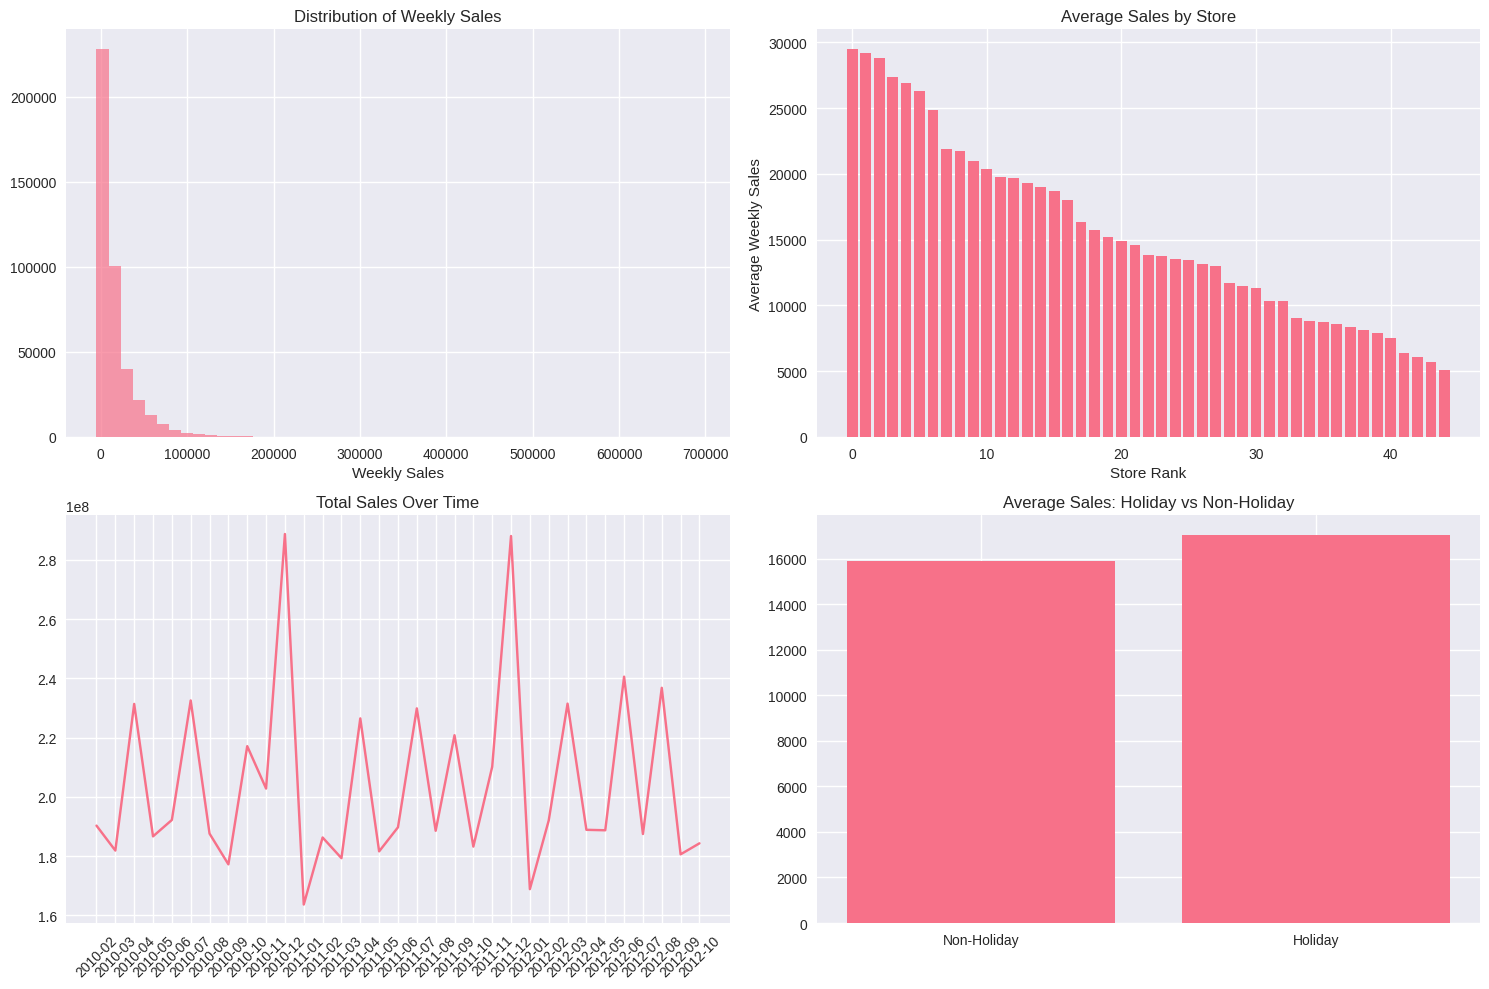

🏃 View run SARIMA_EDA at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/d95e716bbb9a4928a31cf166f4624296
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7
🏃 View run SARIMA_Preprocessing at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/05e75dc0a4f34c5692aa6a7c7f8607dd
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7
🏃 View run SARIMA_Model_Training at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/7f492cdc59e448dd816e7afa009aed80
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7


🏃 View run SARIMA_Forecasting at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/034a831590cc4ca29713f836bf0a6a69
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7
🏃 View run SARIMA_Evaluation at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/323e6f4dcbc2468a9d0ad6fe3d8c14e4
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7


2025/08/03 07:58:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run SARIMA_Model_Registration at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7/runs/4ab55bb9ba71482bab04292ff900075f
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/7


In [36]:
forecaster, submission, filename = run_full_pipeline(max_combinations=50)